In [1]:
pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 21.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import pandas as pd, datetime
from datetime import timedelta
import pandas_profiling as pp

import numpy as np
from time import time

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit
from sklearn import model_selection, metrics

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import random

RANDOM_SEED = 42
def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
seed_everything()

In [5]:
#load our data
dataset = pd.read_csv('/content/drive/MyDrive/project1/Task_1/TimeSeries okska/dataset.csv')

In [6]:
dataset.head().append(dataset.tail())

,date_to_count,product_id,seller_id,product_category_name,price,sales_quantity
0,2016-09-15,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,beleza_saude,44.99,3
1,2016-10-04,43bb8825dd6838251606e5e4130cfff4,939f6e231201f26803cb5c3a3d2940b3,moveis_decoracao,23.90,2
2,2016-10-04,29bedbfbe73ea473396306b4f0c010ec,5b179e9e8cc7ab6fd113a46ca584da81,utilidades_domesticas,89.90,1
3,2016-10-04,a5c3ddb1a400f50d1cf7138727aec136,817f85dbb65aa3e70831d90fe75cdf89,brinquedos,128.90,1
4,2016-10-04,3ff81cd0e0861e991bb0106c03c113ca,86bb7c4b535e49a541baf3266b1c95b1,brinquedos,379.90,1
76085,2018-08-29,777798445efd625458a90c13f3b3e6e7,5f2684dab12e59f83bef73ae57724e45,brinquedos,63.90,1
76086,2018-08-29,06601c3059e35a3bf65e72f2fd2ac626,6b90f847357d8981edd79a1eb1bf0acb,alimentos,109.90,1
76087,2018-08-29,8d4dac6177fb8134f26fb4c5cc6c0aff,c70c1b0d8ca86052f45a432a38b73958,beleza_saude,91.55,5
76088,2018-08-29,d04857e7b4b708ee8b8b9921163edba3,9f505651f4a6abe901a56cdc21508025,informatica_acessorios,84.99,1
76089,2018-09-03,b98992ea80b467987a7fbb88e7f2076a,25be943a321c8938947bdaabca979a90,moveis_cozinha_area_de_servico_jantar_e_jardim,145.00,1


In [7]:
df = dataset.copy()
df = df.rename(columns={'date_to_count': 'date'})
df

,date,product_id,seller_id,product_category_name,price,sales_quantity
0,2016-09-15,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,beleza_saude,44.99,3
1,2016-10-04,43bb8825dd6838251606e5e4130cfff4,939f6e231201f26803cb5c3a3d2940b3,moveis_decoracao,23.90,2
2,2016-10-04,29bedbfbe73ea473396306b4f0c010ec,5b179e9e8cc7ab6fd113a46ca584da81,utilidades_domesticas,89.90,1
3,2016-10-04,a5c3ddb1a400f50d1cf7138727aec136,817f85dbb65aa3e70831d90fe75cdf89,brinquedos,128.90,1
4,2016-10-04,3ff81cd0e0861e991bb0106c03c113ca,86bb7c4b535e49a541baf3266b1c95b1,brinquedos,379.90,1
...,...,...,...,...,...,...
76085,2018-08-29,777798445efd625458a90c13f3b3e6e7,5f2684dab12e59f83bef73ae57724e45,brinquedos,63.90,1
76086,2018-08-29,06601c3059e35a3bf65e72f2fd2ac626,6b90f847357d8981edd79a1eb1bf0acb,alimentos,109.90,1
76087,2018-08-29,8d4dac6177fb8134f26fb4c5cc6c0aff,c70c1b0d8ca86052f45a432a38b73958,beleza_saude,91.55,5
76088,2018-08-29,d04857e7b4b708ee8b8b9921163edba3,9f505651f4a6abe901a56cdc21508025,informatica_acessorios,84.99,1


In [8]:
df['date'] = pd.DatetimeIndex(df.date)

In [9]:
df0 = df.copy()
df0['date'] = pd.to_datetime(df0['date'])
df0.index = df0['date']
del df0['date']
df0.head()
df_interpol = df0.groupby(['product_id', 'seller_id']).resample('D').mean()
df_interpol[['price']] = df_interpol[['price']].interpolate()
df_interpol['sales_quantity'] = df_interpol['sales_quantity'].fillna(0)
df_interpol

price  sales_quantity
product_id                       seller_id                        date                             
000b8f95fcb9e0096488278317764d19 40ec8ab6cdafbcc4f544da38c67da39a 2018-08-01  58.90             1.0
                                                                  2018-08-02  58.90             0.0
                                                                  2018-08-03  58.90             0.0
                                                                  2018-08-04  58.90             0.0
                                                                  2018-08-05  58.90             0.0
...                                                                             ...             ...
fffdb2d0ec8d6a61f0a0a0db3f25b441 9f505651f4a6abe901a56cdc21508025 2018-08-06  34.99             0.0
                                                                  2018-08-07  34.99             1.0
                                                                  2018-08-08  34.99             0.0
                                                                  2018-08-09  34.99             0.0
                                                                  2018-08-10  34.99             1.0

[1873042 rows x 2 columns]

In [10]:
df_interpol = df_interpol.reset_index()
df_interpol.head()

,product_id,seller_id,date,price,sales_quantity
0,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-01,58.9,1.0
1,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-02,58.9,0.0
2,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-03,58.9,0.0
3,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-04,58.9,0.0
4,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-05,58.9,0.0


In [11]:
prod_cats = df[['product_id', 'product_category_name']].groupby(['product_id', 'product_category_name']).count().reset_index()
prod_cats

,product_id,product_category_name
0,000b8f95fcb9e0096488278317764d19,utilidades_domesticas
1,00126f27c813603687e6ce486d909d01,cool_stuff
2,001795ec6f1b187d37335e1c4704762e,consoles_games
3,001b72dfd63e9833e8c02742adf472e3,moveis_decoracao
4,00210e41887c2a8ef9f791ebc780cc36,beleza_saude
...,...,...
14673,ffedbd68fa6f44e788ff6c2db8094715,livros_tecnicos
14674,ffef256879dbadcab7e77950f4f4a195,artigos_de_natal
14675,fff0a542c3c62682f23305214eaeaa24,papelaria
14676,fff6177642830a9a94a0f2cba5e476d1,cool_stuff


In [12]:
new_df = pd.merge(df_interpol, prod_cats, how="left", on="product_id")

In [13]:
df = new_df

In [14]:
df.head(50)

,product_id,seller_id,date,price,sales_quantity,product_category_name
0,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-01,58.9,1.0,utilidades_domesticas
1,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-02,58.9,0.0,utilidades_domesticas
2,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-03,58.9,0.0,utilidades_domesticas
3,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-04,58.9,0.0,utilidades_domesticas
4,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-05,58.9,0.0,utilidades_domesticas
5,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-06,58.9,0.0,utilidades_domesticas
6,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-07,58.9,0.0,utilidades_domesticas
7,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-08,58.9,0.0,utilidades_domesticas
8,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-09,58.9,0.0,utilidades_domesticas
9,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-10,58.9,1.0,utilidades_domesticas


In [15]:
# get year
df['date_year'] = df.date.dt.year.astype(np.uint16)
# get month
df['date_month'] = df.date.dt.month.astype(np.uint8)
# get weekday
df['date_weekday'] = df.date.dt.weekday.astype(np.uint8)
# get week of year
df['date_weekofyear'] = df.date.dt.week.astype(np.uint8)
# check weekend
df['is_weekend'] = df.date_weekday.isin([5,6])*1
# get quarter
df['quarter'] = df.date.dt.quarter.astype(np.uint8)
# get season
df['season'] = df['date_month'] % 12 // 3 + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [16]:
#add holidays
from datetime import date
import holidays
bz_holidays = holidays.Brazil()
df['holiday'] = df.index.isin([d.date() for d in bz_holidays])
df['holiday'] = df['holiday'].map({False: 0, True: 1})

In [17]:
# #increased/decreased in price features

# gp_product_price = df.sort_values('date').groupby(['product_id'], as_index=False).agg({'price':[np.min, np.max]})
# gp_product_price.columns = ['product_id', 'hist_min_product_price', 'hist_max_product_price']

# df = pd.merge(df, gp_product_price, on='product_id', how='left')

In [18]:
# df['price_increase'] = df['price'] - df['hist_min_product_price']
# df['price_decrease'] = df['hist_max_product_price'] - df['price']

In [19]:
print(df.shape)
df.head(3)

(1873042, 14)


,product_id,seller_id,date,price,sales_quantity,product_category_name,date_year,date_month,date_weekday,date_weekofyear,is_weekend,quarter,season,holiday
0,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-01,58.9,1.0,utilidades_domesticas,2018,8,2,31,0,3,3,0
1,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-02,58.9,0.0,utilidades_domesticas,2018,8,3,31,0,3,3,0
2,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-03,58.9,0.0,utilidades_domesticas,2018,8,4,31,0,3,3,0


In [20]:
# check range
dmin = df.date.dt.date.min()
dmax = df.date.dt.date.max()

print('Time range: {} to {}'.format(dmin, dmax))
# date time passed
df['date_time_passed'] = (df.date.dt.date - dmin).dt.days

Time range: 2016-09-15 to 2018-09-03


In [21]:
df.head(3)

,product_id,seller_id,date,price,sales_quantity,product_category_name,date_year,date_month,date_weekday,date_weekofyear,is_weekend,quarter,season,holiday,date_time_passed
0,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-01,58.9,1.0,utilidades_domesticas,2018,8,2,31,0,3,3,0,685
1,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-02,58.9,0.0,utilidades_domesticas,2018,8,3,31,0,3,3,0,686
2,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-03,58.9,0.0,utilidades_domesticas,2018,8,4,31,0,3,3,0,687


In [22]:
# encoding
from sklearn import preprocessing
categorical = ['product_category_name']

label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

In [23]:
df.head(50)

,product_id,seller_id,date,price,sales_quantity,product_category_name,date_year,date_month,date_weekday,date_weekofyear,is_weekend,quarter,season,holiday,date_time_passed
0,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-01,58.9,1.0,72,2018,8,2,31,0,3,3,0,685
1,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-02,58.9,0.0,72,2018,8,3,31,0,3,3,0,686
2,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-03,58.9,0.0,72,2018,8,4,31,0,3,3,0,687
3,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-04,58.9,0.0,72,2018,8,5,31,1,3,3,0,688
4,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-05,58.9,0.0,72,2018,8,6,31,1,3,3,0,689
5,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-06,58.9,0.0,72,2018,8,0,32,0,3,3,0,690
6,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-07,58.9,0.0,72,2018,8,1,32,0,3,3,0,691
7,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-08,58.9,0.0,72,2018,8,2,32,0,3,3,0,692
8,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-09,58.9,0.0,72,2018,8,3,32,0,3,3,0,693
9,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-10,58.9,1.0,72,2018,8,4,32,0,3,3,0,694


In [24]:
df = df.sort_values(by='date')

In [25]:
df.index = df['date']
del df['date']

In [26]:
y = df.sales_quantity
y.shape

(1873042,)

In [89]:
day_to_dataset = df.index[-1] - timedelta(days=90)
day_to_test = df.index[-1] - timedelta(days=21)

In [90]:
day_to_test

Timestamp('2018-08-13 00:00:00')

In [91]:
#split train/test
train = df[(df.index > day_to_dataset) & (df.index <= day_to_test)].copy()
test = df[df.index > day_to_test].copy()

In [92]:
len(test)

9068

In [93]:
# X_train = train.drop(columns = ['product_id', 'seller_id', 'sales_quantity'])
# X_test = test.drop(columns = ['product_id', 'seller_id', 'sales_quantity'])

In [94]:
y_train = train['sales_quantity']
X_train = train.drop(columns = ['product_id', 'seller_id', 'sales_quantity'])
y_test = test['sales_quantity']
X_test = test.drop(columns = ['product_id', 'seller_id', 'sales_quantity'])
print(len(y_train), len(train), len(y_test), len(test))

192922 192922 9068 9068


In [95]:
y_test

date
2018-08-14    0.0
2018-08-14    0.0
2018-08-14    0.0
2018-08-14    0.0
2018-08-14    0.0
             ... 
2018-08-30    0.0
2018-08-31    0.0
2018-09-01    0.0
2018-09-02    0.0
2018-09-03    1.0
Name: sales_quantity, Length: 9068, dtype: float64

In [96]:
#lgbm
lgb_reg = lgb.LGBMRegressor()

In [97]:
# #xgb
# xgb_reg = xgb.XGBRegressor()

In [98]:
lgb_reg.fit(X_train, y_train)

LGBMRegressor()

In [99]:
valid_test = pd.DataFrame(y_test.values, columns=['target'])

In [100]:
valid_test

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
9063,0.0
9064,0.0
9065,0.0
9066,0.0


In [101]:
len(lgb_reg.predict(X_test))

9068

In [102]:
valid_test['preds'] = lgb_reg.predict(X_test)

In [103]:
valid_test

,target,preds
0,0.0,0.170413
1,0.0,0.110743
2,0.0,0.166410
3,0.0,0.147215
4,0.0,0.192741
...,...,...
9063,0.0,0.142477
9064,0.0,0.101261
9065,0.0,0.097680
9066,0.0,0.084436


In [104]:
valid_test = valid_test[valid_test['target'] != 0]

In [105]:
print(mean_absolute_error(valid_test['target'], valid_test['preds']))
print(mean_absolute_percentage_error(valid_test['target'], np.round(valid_test['preds'])))

1.0368112559930396
0.9909297625063163


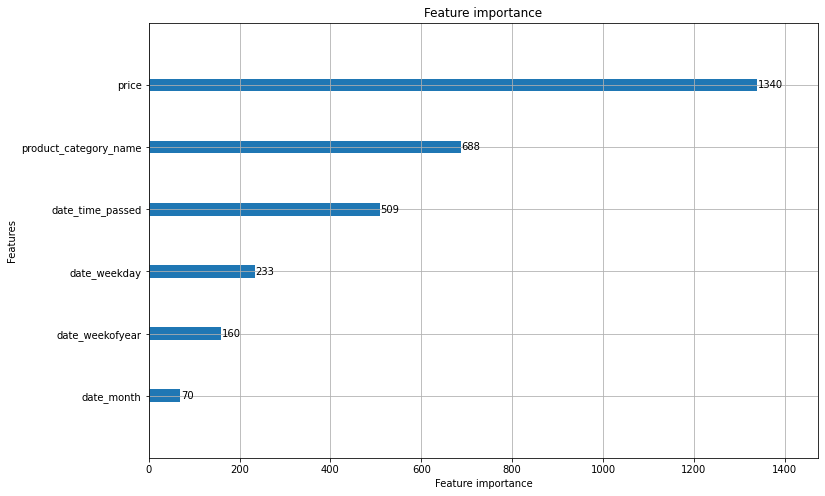

In [106]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

lgb.plot_importance(lgb_reg, ax=ax)

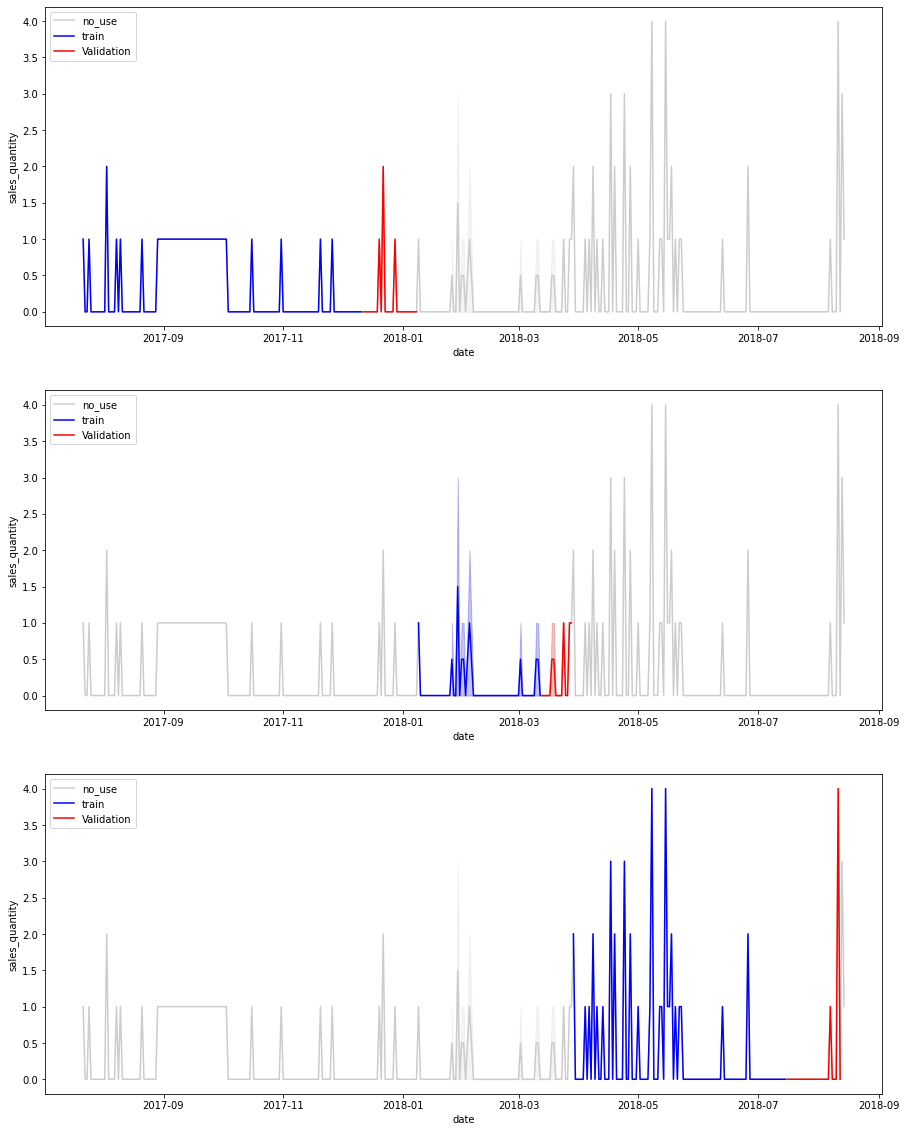

In [107]:
def rolling_time_series_split(df,splits):
    n_samples = len(df)
    folds = n_samples // splits
    indices = np.arange(n_samples)

    margin = 0
    for i in range(splits): 
        start = i * folds  
        stop = start + folds  
        temp = int(0.8 * (stop - start)) + start #If you want to change the data ratio of train/Validation, change the 0.8 part.
        yield indices[start: temp], indices[temp + margin: stop]  

fig, axes = plt.subplots(3, 1, figsize=(15, 20))  
for i, (train_index, test_index) in enumerate(rolling_time_series_split(df[df['product_id'] == '363218ba55c610b750224f90bdd34be1'],3)):  
    sns.lineplot(data=df[df['product_id'] == '363218ba55c610b750224f90bdd34be1'], x='date', y='sales_quantity', ax=axes[i], label='no_use',color="0.8")  
    sns.lineplot(data=df[df['product_id'] == '363218ba55c610b750224f90bdd34be1'].iloc[train_index], x='date', y='sales_quantity', ax=axes[i], label='train',color="b")  
    sns.lineplot(data=df[df['product_id'] == '363218ba55c610b750224f90bdd34be1'].iloc[test_index], x='date', y='sales_quantity', ax=axes[i], label='Validation',color="r")  

plt.show()

#Create more features

In [ ]:
# Get rolling features
# Min value
f_min = lambda x: x.rolling(window=7, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=7, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=7, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=7, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    df[('sales_%s' % function_name[i])] = df.sort_values('date').groupby(['product_id'])['sales_quantity'].apply(function_list[i])

# Fill the empty std features with 0
df['sales_std'].fillna(0, inplace=True)

KeyboardInterrupt: ignored

In [ ]:
lag_list = [21, 22, 23]

for lag in lag_list:
    ft_name = ('sales_shifted%s' % lag)
    df[ft_name] = df.sort_values('date').groupby(['product_id', 'saller_id'])['sales_quantity'].shift(lag)
    # Fill the empty shifted features with 0
    df[ft_name].fillna(0, inplace=True)

In [ ]:
train = df[(df.index > day_to_dataset) & (df.index <= day_to_test)].copy()
test = df[df.index > day_to_test].copy()

In [ ]:
#split train/test
train = df[:len(train)]
test = df[len(train):]

X_train = train.drop(columns = ['product_id', 'sales_quantity', 'date'])
X_test = test.drop(columns = ['product_id', 'sales_quantity', 'date'])

In [ ]:
lgb_reg.fit(X_train, y_train)

In [ ]:
!pip install sklearn.metrics.mean_absolute_percentage_error

In [ ]:
#lgb
from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_error(y_test, lgb_reg.predict(X_test))
mean_absolute_percentage_error(y_test, lgb_reg.predict(X_test))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

lgb.plot_importance(lgb_reg, ax=ax)

In [ ]:
X_test['preds'] = lgb_reg.predict(X_test)
X_test['real'] = y_test

In [ ]:
X_test[X_test['product_category_name'] == 46]